In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/My Drive/OMDS_firstassignment_MLP/')

In [5]:
import numpy as np
import pandas as pd
from Functions_MLP import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(42)

In [6]:
# Replace 'your_file_id_here' with the actual file ID
FILE_ID = '1eJoLgGqnX7Le1vOTeioCsp_dRtuxmo4O'
# Read the CSV file into a DataFrame'
download_url = f'https://drive.google.com/uc?id={FILE_ID}'

# Load dataset
data = pd.read_csv(download_url)

# Extract features (X) and target (y)
# Splits the data into:
# - Features (X): All columns except 'gt'.
# - Target (y): The 'gt' column (ground truth or target variable).
X = data.drop(columns=['gt']).values  # Features
y = data['gt'].values  # Target(age column)


# Split the data into training (80%) and test (20%) sets
# Divides the dataset into:
# - Training set: 80% of the data (used for training the model).
# - Test set: 20% of the data (used for evaluating the model's performance).
# `random_state=42` ensures reproducibility of the splits.
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Normalize the training set using Z-score normalization (Standardization)
x_mean = np.mean(X_train_raw, axis=0)
x_std = np.std(X_train_raw, axis=0)


# Normalize the training data
X_train = (X_train_raw - x_mean) / x_std


# Normalize the test set using Z-score normalization (Standardization)
# The test set is normalized using training data statistics mean and standard deviation
# to avoid any potential data leakage from the test set.
# This ensures that information from the test set does not influence the validation
# and test process
X_test = (X_test_raw - x_mean) / x_std


# Print the shapes of the training and test datasets to ensure everything is processed correctly.
print(f"Training set shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set shape: X_test = {X_test.shape}, y_test = {y_test.shape}")


Training set shape: X_train = (16380, 32), y_train = (16380,)
Test set shape: X_test = (4095, 32), y_test = (4095,)


In [8]:
# Define the hyperparameters and their possible values
# The hyperparameter space includes:
# - hidden_layer_sizes: Different configurations for the number of neurons in hidden layers.
# - lambda_reg: L2 regularization strengths to prevent overfitting.
# - activation: Activation functions to introduce non-linearity into the network.
# - initialization_mode: Methods for initializing weights to ensure proper convergence.
hyperparameter_space = {
    'hidden_layer_sizes': [
        [32, 16],
        [64, 32],
        [128, 64],
        [64, 32, 32],
        [128, 64, 32],
        [128, 64, 32, 16]],
    'lambda_reg': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'swish'],
    'initialization_mode': ['he', 'xavier']}

# Number of folds for cross-validation
# k determines the number of splits in k-fold cross-validation.
# KFold ensures that the dataset is divided into `k` parts (folds),
# with `shuffle=True` to randomize the order of samples.
# `random_state=42` ensures reproducibility of the splits.
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Generate all combinations of hyperparameters
# This creates a Cartesian product of all possible combinations of hyperparameter values.
# Each combination is a tuple representing a specific configuration.
hyperparameter_combinations = list(itertools.product(
    hyperparameter_space['hidden_layer_sizes'],  # Possible hidden layer configurations
    hyperparameter_space['lambda_reg'],         # L2 regularization strengths
    hyperparameter_space['activation'],         # Activation functions
    hyperparameter_space['initialization_mode'])) # Weight initialization modes

In [9]:
# Dictionary to store the best combination of hyperparameters
best_hyperparams = None

# Initialize best CV loss to a large number to ensure any actual loss will be smaller
best_cv_loss = np.inf

# List to store the results for each hyperparameter combination
cv_results = []

# Start the hyperparameter search loop with a progress bar
with tqdm(total=len(hyperparameter_combinations), desc="Hyperparameter Search") as pbar:
    # Loop through each hyperparameter combination
    for idx, (hidden_sizes, lambda_reg, activation, init_mode) in enumerate(hyperparameter_combinations):

        # Display the current combination being evaluated
        tqdm.write(f"Combination {idx+1}/{len(hyperparameter_combinations)}:")
#         tqdm.write(f"Hidden Sizes: {hidden_sizes}, Lambda: {lambda_reg}, Activation: {activation}, Init Mode: {init_mode}")

        # Lists to store fold-level results
        val_mape_folds = []              # Validation MAPE per fold
        val_reg_errors_folds = []        # Validation regularized error per fold
        train_initial_mape_folds = []    # Initial training MAPE per fold (before training)
        train_final_mape_folds = []      # Final training MAPE per fold (after training)
        fold_opt_results = []            # Optimization results per fold


        # Perform k-fold cross-validation
        for train_index, val_index in kf.split(X_train):
            # Split the training data into training and validation sets for the current fold
            X_cv_train, X_val = X_train[train_index], X_train[val_index]
            y_cv_train, y_val = y_train[train_index], y_train[val_index]

            # Instantiate the model with the current hyperparameters
            model_cv = NeuralNetwork(
                input_size=X_train.shape[1],  # Number of input features
                hidden_layer_sizes=hidden_sizes,  # Current hidden layer configuration
                lambda_reg=lambda_reg,  # Regularization parameter
                initialization_mode=init_mode,  # Weight initialization method
                activation=activation)  # Activation function


            # Compute initial training MAPE (before any training)
            train_activations_initial, _ = model_cv.forward(X_cv_train)
            initial_train_mape = mean_absolute_percentage_error(y_cv_train.flatten(), train_activations_initial[len(model_cv.weights)].flatten())
            train_initial_mape_folds.append(initial_train_mape)


            # Train the model on the training fold
            model_cv , optimization_results_cv = train_nn(X_cv_train, y_cv_train, model_cv, maxiter=200,function_tolerance=1e-4, max_norm=5.0)

            # Store the optimization results for the current fold
            fold_opt_results.append(optimization_results_cv)

            # Final training MAPE (after training)
            train_activations_final, _ = model_cv.forward(X_cv_train)
            final_train_mape = mean_absolute_percentage_error(y_cv_train.flatten(), train_activations_final[len(model_cv.weights)].flatten())
            train_final_mape_folds.append(final_train_mape)


            # Compute validation predictions and regularized error
            val_activations, _ = model_cv.forward(X_val)
            val_reg_error = model_cv.compute_loss(val_activations, y_val)
            val_reg_errors_folds.append(val_reg_error)

            # Compute validation MAPE(Mean Absolute Percentage Error)
            output_layer_index = len(model_cv.weights)  # Index of the output layer
            y_val_pred = val_activations[output_layer_index].flatten()  # Predicted values
            val_mape = mean_absolute_percentage_error(y_val.flatten(), y_val_pred)
            val_mape_folds.append(val_mape)


        # Compute the average validation Mape across folds for the current combination
        avg_val_mape  = np.mean(val_mape_folds)

        #compute the average of regularized error across folds on the validation set.
        avg_val_reg_error = np.mean(val_reg_errors_folds)

        #Compute the average MAPE across folds for the training set
        avg_initial_train_mape = np.mean(train_initial_mape_folds)
        avg_final_train_mape = np.mean(train_final_mape_folds)


        # Aggregate optimization results across folds
        avg_initial_loss = np.mean([res['initial_loss'] for res in fold_opt_results])
        avg_final_loss = np.mean([res['Final_Loss'] for res in fold_opt_results])
        avg_iterations = np.mean([res['Iteration_number'] for res in fold_opt_results])
        avg_optimization_time = np.mean([res['optimization_time_seconds'] for res in fold_opt_results])
        success_rate = np.mean([res['Optimization_Success'] for res in fold_opt_results]) * 100  # Success rate as percentage
        fold_messages = [res['Optimization_message'] for res in fold_opt_results]
        unique_messages = list(set(fold_messages))  # Get unique messages across folds

        # Log average validation MAPE for this combination
#         tqdm.write(f"Average CV MAPE: {avg_val_mape:.4f}%\n")

        # Record the results for this combination
        cv_results.append({
            'hidden_layer_sizes': hidden_sizes,
            'lambda_reg': lambda_reg,
            'activation': activation,
            'initialization_mode': init_mode,
            'avg_val_mape': avg_val_mape,
            'avg_val_reg_error': avg_val_reg_error,
            'avg_initial_loss': avg_initial_loss,
            'avg_final_loss': avg_final_loss,
            'avg_initial_train_mape': avg_initial_train_mape,
            'avg_final_train_mape': avg_final_train_mape,
            'avg_iterations': avg_iterations,
            'avg_optimization_time_seconds': avg_optimization_time,
            'success_rate': success_rate,
            'unique_messages': unique_messages})

        # Update the best hyperparameters if the current combination performs better
        if avg_val_mape  < best_cv_loss:
            best_cv_loss  = avg_val_mape  # Update the best cross-validation loss
            best_hyperparams = {  # Update the best hyperparameter combination
                'hidden_layer_sizes': hidden_sizes,
                'lambda_reg': lambda_reg,
                'activation': activation,
                'initialization_mode': init_mode}


        print(f"""
                number of layers: {len(hidden_sizes)}
                number of neurons: {hidden_sizes}
                activation function: {activation}
                initialization_mode: {init_mode}
                Lambda: {lambda_reg}
                optimization solver: L-BFGS-B optimizer
                number of iterations: {avg_iterations}
                optimization time: {avg_optimization_time}
                Training Error: {avg_final_loss}
                training MAPE: {avg_final_train_mape}
                """)

        # Update the progress bar
        pbar.update(1)

# Save the cross-validation results to a CSV file
pd.DataFrame(cv_results).to_csv("Hyperparameter_Space_Result.csv", index=False)


Hyperparameter Search:   0%|          | 0/108 [00:00<?, ?it/s]

Combination 1/108:


Hyperparameter Search:   1%|          | 1/108 [00:11<20:53, 11.71s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 42.8 
                optimization time: 2.2768073081970215 
                Training Error: 97.60416612658851  
                training MAPE: 23.407856333432207
                
Combination 2/108:


Hyperparameter Search:   2%|▏         | 2/108 [00:24<22:04, 12.49s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 41.0 
                optimization time: 2.555920362472534 
                Training Error: 97.62725118266329  
                training MAPE: 23.37985334000021
                
Combination 3/108:


Hyperparameter Search:   3%|▎         | 3/108 [00:38<22:45, 13.00s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 76.8 
                optimization time: 2.6458597660064695 
                Training Error: 96.99708671462727  
                training MAPE: 23.184298672289334
                
Combination 4/108:


Hyperparameter Search:   4%|▎         | 4/108 [00:52<23:05, 13.32s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 69.8 
                optimization time: 2.708135986328125 
                Training Error: 97.82288583002575  
                training MAPE: 23.363705195920048
                
Combination 5/108:


Hyperparameter Search:   5%|▍         | 5/108 [01:07<24:16, 14.14s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 47.0 
                optimization time: 3.0471840858459474 
                Training Error: 97.9548054489052  
                training MAPE: 23.610324034022902
                
Combination 6/108:


Hyperparameter Search:   6%|▌         | 6/108 [01:28<27:45, 16.33s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 45.2 
                optimization time: 4.047631120681762 
                Training Error: 98.02559682677011  
                training MAPE: 23.41338201052806
                
Combination 7/108:


Hyperparameter Search:   6%|▋         | 7/108 [01:40<25:22, 15.08s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 50.2 
                optimization time: 2.4480876445770265 
                Training Error: 98.30865751178104  
                training MAPE: 23.33120188736344
                
Combination 8/108:


Hyperparameter Search:   7%|▋         | 8/108 [01:54<24:09, 14.50s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 48.6 
                optimization time: 2.6017383098602296 
                Training Error: 97.90450919448327  
                training MAPE: 23.33259497760268
                
Combination 9/108:


Hyperparameter Search:   8%|▊         | 9/108 [02:10<24:48, 15.04s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 102.6 
                optimization time: 3.191147470474243 
                Training Error: 100.41202927489915  
                training MAPE: 23.27242952686993
                
Combination 10/108:


Hyperparameter Search:   9%|▉         | 10/108 [02:25<24:48, 15.19s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 92.2 
                optimization time: 3.040596914291382 
                Training Error: 101.00650047927469  
                training MAPE: 23.183248901444482
                
Combination 11/108:


Hyperparameter Search:  10%|█         | 11/108 [02:46<27:25, 16.97s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 44.4 
                optimization time: 4.141672611236572 
                Training Error: 99.31462635730826  
                training MAPE: 23.472367637834616
                
Combination 12/108:


Hyperparameter Search:  11%|█         | 12/108 [02:57<23:56, 14.96s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 32.0 
                optimization time: 2.0143546581268312 
                Training Error: 99.20365165189679  
                training MAPE: 23.405756011872626
                
Combination 13/108:


Hyperparameter Search:  12%|█▏        | 13/108 [03:12<23:49, 15.05s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 68.6 
                optimization time: 3.0013331890106203 
                Training Error: 103.86379250393729  
                training MAPE: 23.371242186908734
                
Combination 14/108:


Hyperparameter Search:  13%|█▎        | 14/108 [03:33<26:18, 16.79s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 93.4 
                optimization time: 4.111060094833374 
                Training Error: 99.0916637292876  
                training MAPE: 23.2890013349431
                
Combination 15/108:


Hyperparameter Search:  14%|█▍        | 15/108 [03:52<27:15, 17.59s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 102.8 
                optimization time: 3.8206674098968505 
                Training Error: 114.30546292977894  
                training MAPE: 23.4606818778135
                
Combination 16/108:


Hyperparameter Search:  15%|█▍        | 16/108 [04:13<28:30, 18.59s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 122.0 
                optimization time: 4.132207012176513 
                Training Error: 112.22751729830395  
                training MAPE: 23.314401571372606
                
Combination 17/108:


Hyperparameter Search:  16%|█▌        | 17/108 [04:42<32:48, 21.63s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 92.8 
                optimization time: 5.664934539794922 
                Training Error: 100.41439884454365  
                training MAPE: 23.2555816032583
                
Combination 18/108:


Hyperparameter Search:  17%|█▋        | 18/108 [05:09<34:46, 23.19s/it]


                number of layers: 2  
                number of neurons: [32, 16] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 73.2 
                optimization time: 5.273758411407471 
                Training Error: 101.39588348010926  
                training MAPE: 23.244383780480767
                
Combination 19/108:


Hyperparameter Search:  18%|█▊        | 19/108 [05:30<33:37, 22.67s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 51.0 
                optimization time: 4.19371452331543 
                Training Error: 97.11297486579244  
                training MAPE: 23.282178874350937
                
Combination 20/108:


Hyperparameter Search:  19%|█▊        | 20/108 [05:52<33:02, 22.53s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 42.6 
                optimization time: 4.322039222717285 
                Training Error: 98.46654453675252  
                training MAPE: 23.347561678810916
                
Combination 21/108:


Hyperparameter Search:  19%|█▉        | 21/108 [06:23<36:14, 24.99s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 77.0 
                optimization time: 6.005516386032104 
                Training Error: 96.50633273068456  
                training MAPE: 23.142788801208845
                
Combination 22/108:


Hyperparameter Search:  20%|██        | 22/108 [06:55<38:45, 27.04s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 78.0 
                optimization time: 6.253719615936279 
                Training Error: 96.33485207904258  
                training MAPE: 23.14262675669945
                
Combination 23/108:


Hyperparameter Search:  21%|██▏       | 23/108 [07:32<42:33, 30.04s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 49.2 
                optimization time: 7.290672874450683 
                Training Error: 98.03028727108612  
                training MAPE: 23.400707730165294
                
Combination 24/108:


Hyperparameter Search:  22%|██▏       | 24/108 [08:11<45:50, 32.75s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 48.0 
                optimization time: 7.649347925186158 
                Training Error: 97.77212404865007  
                training MAPE: 23.313426629106118
                
Combination 25/108:


Hyperparameter Search:  23%|██▎       | 25/108 [08:36<42:06, 30.44s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 41.2 
                optimization time: 4.900776529312134 
                Training Error: 99.82389805856278  
                training MAPE: 23.354079722234864
                
Combination 26/108:


Hyperparameter Search:  24%|██▍       | 26/108 [09:06<41:21, 30.26s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 60.0 
                optimization time: 5.844239044189453 
                Training Error: 97.60729469555538  
                training MAPE: 23.252546275317194
                
Combination 27/108:


Hyperparameter Search:  25%|██▌       | 27/108 [09:39<41:49, 30.98s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 84.4 
                optimization time: 6.409554529190063 
                Training Error: 99.2958350328934  
                training MAPE: 23.15280191156997
                
Combination 28/108:


Hyperparameter Search:  26%|██▌       | 28/108 [10:11<42:03, 31.54s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 89.0 
                optimization time: 6.445137929916382 
                Training Error: 99.89183965322817  
                training MAPE: 23.20638429040945
                
Combination 29/108:


Hyperparameter Search:  27%|██▋       | 29/108 [10:58<47:36, 36.16s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 62.4 
                optimization time: 9.246961498260498 
                Training Error: 99.18363801619526  
                training MAPE: 23.29475455222511
                
Combination 30/108:


Hyperparameter Search:  28%|██▊       | 30/108 [11:42<49:56, 38.41s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 47.4 
                optimization time: 8.592604207992554 
                Training Error: 98.99925737948595  
                training MAPE: 23.40172504778833
                
Combination 31/108:


Hyperparameter Search:  29%|██▊       | 31/108 [12:11<45:43, 35.62s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 62.8 
                optimization time: 5.7307209968566895 
                Training Error: 111.12424893417361  
                training MAPE: 23.24117744415469
                
Combination 32/108:


Hyperparameter Search:  30%|██▉       | 32/108 [12:43<43:39, 34.47s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 70.0 
                optimization time: 6.2599958896636965 
                Training Error: 104.94744383027376  
                training MAPE: 23.617236821138096
                
Combination 33/108:


Hyperparameter Search:  31%|███       | 33/108 [13:42<52:23, 41.91s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 125.8 
                optimization time: 11.735517597198486 
                Training Error: 110.64513527863714  
                training MAPE: 23.19535239907649
                
Combination 34/108:


Hyperparameter Search:  31%|███▏      | 34/108 [14:32<54:45, 44.40s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 124.0 
                optimization time: 9.919440364837646 
                Training Error: 108.67671968622957  
                training MAPE: 23.262603417823545
                
Combination 35/108:


Hyperparameter Search:  32%|███▏      | 35/108 [15:13<52:42, 43.33s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 56.8 
                optimization time: 8.022788333892823 
                Training Error: 112.39902904488308  
                training MAPE: 23.79831984628285
                
Combination 36/108:


Hyperparameter Search:  33%|███▎      | 36/108 [16:04<54:36, 45.51s/it]


                number of layers: 2  
                number of neurons: [64, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 72.8 
                optimization time: 9.988372468948365 
                Training Error: 102.9644048619655  
                training MAPE: 23.326809898447248
                
Combination 37/108:


Hyperparameter Search:  34%|███▍      | 37/108 [17:25<1:06:41, 56.35s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 54.2 
                optimization time: 16.085125112533568 
                Training Error: 96.87934758293821  
                training MAPE: 23.29499888891444
                
Combination 38/108:


Hyperparameter Search:  35%|███▌      | 38/108 [18:47<1:14:30, 63.87s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 57.6 
                optimization time: 16.05698628425598 
                Training Error: 96.74810523697256  
                training MAPE: 23.25004143638007
                
Combination 39/108:


Hyperparameter Search:  36%|███▌      | 39/108 [20:39<1:30:13, 78.46s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 85.6 
                optimization time: 22.238708448410033 
                Training Error: 95.98384835288759  
                training MAPE: 23.07705946696745
                
Combination 40/108:


Hyperparameter Search:  37%|███▋      | 40/108 [22:19<1:36:15, 84.93s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 78.0 
                optimization time: 19.742778158187868 
                Training Error: 96.19650787763479  
                training MAPE: 23.093738064949584
                
Combination 41/108:


Hyperparameter Search:  38%|███▊      | 41/108 [23:51<1:37:07, 86.97s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 39.0 
                optimization time: 18.066543769836425 
                Training Error: 98.22580196250757  
                training MAPE: 23.351382520425567
                
Combination 42/108:


Hyperparameter Search:  39%|███▉      | 42/108 [25:54<1:47:24, 97.64s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 50.2 
                optimization time: 24.190005445480345 
                Training Error: 97.31997065306176  
                training MAPE: 23.426920283894937
                
Combination 43/108:


Hyperparameter Search:  40%|███▉      | 43/108 [26:53<1:33:10, 86.00s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 34.8 
                optimization time: 11.541596174240112 
                Training Error: 102.53855460873498  
                training MAPE: 23.665043530540324
                
Combination 44/108:


Hyperparameter Search:  41%|████      | 44/108 [28:24<1:33:26, 87.60s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 43.2 
                optimization time: 17.95778694152832 
                Training Error: 98.99427187779837  
                training MAPE: 23.324794897582347
                
Combination 45/108:


Hyperparameter Search:  42%|████▏     | 45/108 [30:53<1:51:15, 105.95s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 107.6 
                optimization time: 29.488853788375856 
                Training Error: 99.07434357953122  
                training MAPE: 22.93256845813524
                
Combination 46/108:


Hyperparameter Search:  43%|████▎     | 46/108 [32:27<1:45:58, 102.55s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 71.2 
                optimization time: 18.619841718673705 
                Training Error: 99.73242184049012  
                training MAPE: 23.248813236813614
                
Combination 47/108:


Hyperparameter Search:  44%|████▎     | 47/108 [34:37<1:52:41, 110.85s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 59.2 
                optimization time: 25.68838996887207 
                Training Error: 100.64436460311893  
                training MAPE: 23.25086429683338
                
Combination 48/108:


Hyperparameter Search:  44%|████▍     | 48/108 [36:38<1:53:45, 113.77s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 50.8 
                optimization time: 23.799257135391237 
                Training Error: 98.47881844748464  
                training MAPE: 23.26136536988831
                
Combination 49/108:


Hyperparameter Search:  45%|████▌     | 49/108 [38:32<1:51:48, 113.70s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 53.8 
                optimization time: 22.468418884277344 
                Training Error: 120.90857186806622  
                training MAPE: 23.51454306618833
                
Combination 50/108:


Hyperparameter Search:  46%|████▋     | 50/108 [40:25<1:49:58, 113.77s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 70.0 
                optimization time: 22.513780784606933 
                Training Error: 105.6301305144711  
                training MAPE: 23.304695694405577
                
Combination 51/108:


Hyperparameter Search:  47%|████▋     | 51/108 [43:33<2:08:57, 135.74s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 112.4 
                optimization time: 37.11629548072815 
                Training Error: 112.10420123022895  
                training MAPE: 23.35022016165634
                
Combination 52/108:


Hyperparameter Search:  48%|████▊     | 52/108 [46:16<2:14:29, 144.10s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 112.6 
                optimization time: 32.4129195690155 
                Training Error: 105.66267139813957  
                training MAPE: 23.3289331191582
                
Combination 53/108:


Hyperparameter Search:  49%|████▉     | 53/108 [50:59<2:50:13, 185.70s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 116.0 
                optimization time: 56.25910000801086 
                Training Error: 104.67699317391006  
                training MAPE: 23.28025163601362
                
Combination 54/108:


Hyperparameter Search:  50%|█████     | 54/108 [53:47<2:42:22, 180.42s/it]


                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 63.0 
                optimization time: 33.34971199035645 
                Training Error: 105.69077304735686  
                training MAPE: 23.261501308790535
                
Combination 55/108:


Hyperparameter Search:  51%|█████     | 55/108 [54:16<1:59:20, 135.11s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 44.2 
                optimization time: 5.765715885162353 
                Training Error: 97.50115538945721  
                training MAPE: 23.345068025566363
                
Combination 56/108:


Hyperparameter Search:  52%|█████▏    | 56/108 [54:49<1:30:28, 104.39s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 44.8 
                optimization time: 6.405642032623291 
                Training Error: 97.1859937850844  
                training MAPE: 23.307903259236216
                
Combination 57/108:


Hyperparameter Search:  53%|█████▎    | 57/108 [55:23<1:10:39, 83.12s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 65.8 
                optimization time: 6.53770227432251 
                Training Error: 97.22812862111375  
                training MAPE: 23.343624880805162
                
Combination 58/108:


Hyperparameter Search:  54%|█████▎    | 58/108 [55:51<55:34, 66.68s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 60.0 
                optimization time: 5.496720981597901 
                Training Error: 97.95660985155867  
                training MAPE: 23.30054961724411
                
Combination 59/108:


Hyperparameter Search:  55%|█████▍    | 59/108 [56:40<50:05, 61.33s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 41.8 
                optimization time: 9.604424619674683 
                Training Error: 98.74246580566512  
                training MAPE: 23.45005534978401
                
Combination 60/108:


Hyperparameter Search:  56%|█████▌    | 60/108 [57:30<46:27, 58.07s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 46.4 
                optimization time: 9.921264123916625 
                Training Error: 97.64704927074041  
                training MAPE: 23.344620977242922
                
Combination 61/108:


Hyperparameter Search:  56%|█████▋    | 61/108 [58:02<39:17, 50.15s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 36.4 
                optimization time: 6.189388942718506 
                Training Error: 100.59317660897469  
                training MAPE: 23.322583707980996
                
Combination 62/108:


Hyperparameter Search:  57%|█████▋    | 62/108 [58:30<33:22, 43.53s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 39.4 
                optimization time: 5.489317560195923 
                Training Error: 98.78956942869799  
                training MAPE: 23.366659278131625
                
Combination 63/108:


Hyperparameter Search:  58%|█████▊    | 63/108 [59:06<30:57, 41.28s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 72.0 
                optimization time: 7.067747402191162 
                Training Error: 102.72787905378443  
                training MAPE: 23.260835030071654
                
Combination 64/108:


Hyperparameter Search:  59%|█████▉    | 64/108 [59:47<30:11, 41.16s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 70.6 
                optimization time: 8.0014178276062 
                Training Error: 103.61235405687735  
                training MAPE: 23.473624741333527
                
Combination 65/108:


Hyperparameter Search:  60%|██████    | 65/108 [1:00:35<31:03, 43.33s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 42.8 
                optimization time: 9.529755926132202 
                Training Error: 100.45770326468644  
                training MAPE: 23.419229497047212
                
Combination 66/108:


Hyperparameter Search:  61%|██████    | 66/108 [1:01:21<30:44, 43.92s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 34.2 
                optimization time: 8.889710330963135 
                Training Error: 100.08274511479871  
                training MAPE: 23.467484333813363
                
Combination 67/108:


Hyperparameter Search:  62%|██████▏   | 67/108 [1:02:04<29:59, 43.90s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 54.2 
                optimization time: 8.623401260375976 
                Training Error: 118.59518016626377  
                training MAPE: 23.635801151931
                
Combination 68/108:


Hyperparameter Search:  63%|██████▎   | 68/108 [1:02:40<27:42, 41.56s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 39.8 
                optimization time: 7.093159914016724 
                Training Error: 109.96359873388758  
                training MAPE: 23.37895219250959
                
Combination 69/108:


Hyperparameter Search:  64%|██████▍   | 69/108 [1:03:50<32:23, 49.82s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 116.6 
                optimization time: 13.670874977111817 
                Training Error: 113.54691801463994  
                training MAPE: 23.463047371304196
                
Combination 70/108:


Hyperparameter Search:  65%|██████▍   | 70/108 [1:05:00<35:29, 56.04s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 108.4 
                optimization time: 13.903684329986572 
                Training Error: 112.22304337924122  
                training MAPE: 23.495120757106545
                
Combination 71/108:


Hyperparameter Search:  66%|██████▌   | 71/108 [1:05:58<34:49, 56.47s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 43.6 
                optimization time: 11.29757661819458 
                Training Error: 119.77991592902929  
                training MAPE: 23.399307818994053
                
Combination 72/108:


Hyperparameter Search:  67%|██████▋   | 72/108 [1:06:59<34:51, 58.09s/it]


                number of layers: 3  
                number of neurons: [64, 32, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 43.6 
                optimization time: 12.191401481628418 
                Training Error: 110.1728342296589  
                training MAPE: 23.455675695051767
                
Combination 73/108:


Hyperparameter Search:  68%|██████▊   | 73/108 [1:08:54<43:46, 75.05s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 48.6 
                optimization time: 22.602844333648683 
                Training Error: 97.49304996105268  
                training MAPE: 23.291430737116265
                
Combination 74/108:


Hyperparameter Search:  69%|██████▊   | 74/108 [1:10:27<45:33, 80.38s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 42.6 
                optimization time: 18.297037744522093 
                Training Error: 97.27436053949842  
                training MAPE: 23.30100618587193
                
Combination 75/108:


Hyperparameter Search:  69%|██████▉   | 75/108 [1:12:33<51:47, 94.17s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 81.2 
                optimization time: 24.95558633804321 
                Training Error: 96.97056217825302  
                training MAPE: 23.087859514148146
                
Combination 76/108:


Hyperparameter Search:  70%|███████   | 76/108 [1:14:17<51:41, 96.92s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 61.4 
                optimization time: 20.363081789016725 
                Training Error: 97.62863787558236  
                training MAPE: 23.26315097185209
                
Combination 77/108:


Hyperparameter Search:  71%|███████▏  | 77/108 [1:16:36<56:39, 109.67s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 45.2 
                optimization time: 27.54936456680298 
                Training Error: 98.4073729356679  
                training MAPE: 23.403874058096342
                
Combination 78/108:


Hyperparameter Search:  72%|███████▏  | 78/108 [1:18:48<58:10, 116.35s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 37.2 
                optimization time: 26.035380268096922 
                Training Error: 98.74848384394177  
                training MAPE: 23.508519103533878
                
Combination 79/108:


Hyperparameter Search:  73%|███████▎  | 79/108 [1:20:14<51:52, 107.33s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 35.8 
                optimization time: 16.962741756439208 
                Training Error: 102.41766759772868  
                training MAPE: 23.36202855611494
                
Combination 80/108:


Hyperparameter Search:  74%|███████▍  | 80/108 [1:22:00<49:51, 106.83s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 41.2 
                optimization time: 20.775035238265993 
                Training Error: 99.07610881366621  
                training MAPE: 23.262949694518767
                
Combination 81/108:


Hyperparameter Search:  75%|███████▌  | 81/108 [1:24:27<53:28, 118.83s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 88.6 
                optimization time: 28.961943054199217 
                Training Error: 103.21609465262804  
                training MAPE: 23.2251778330385
                
Combination 82/108:


Hyperparameter Search:  76%|███████▌  | 82/108 [1:26:33<52:30, 121.19s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 69.8 
                optimization time: 24.984127950668334 
                Training Error: 103.53053396096769  
                training MAPE: 23.349354997601008
                
Combination 83/108:


Hyperparameter Search:  77%|███████▋  | 83/108 [1:29:17<55:48, 133.95s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 51.0 
                optimization time: 32.42686543464661 
                Training Error: 102.1212261995033  
                training MAPE: 23.392407459418312
                
Combination 84/108:


Hyperparameter Search:  78%|███████▊  | 84/108 [1:31:43<54:59, 137.47s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 39.0 
                optimization time: 28.74640374183655 
                Training Error: 100.97627962723166  
                training MAPE: 23.584208020042645
                
Combination 85/108:


Hyperparameter Search:  79%|███████▊  | 85/108 [1:34:19<54:52, 143.17s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 57.2 
                optimization time: 31.00759563446045 
                Training Error: 132.1433050048964  
                training MAPE: 23.366358463884342
                
Combination 86/108:


Hyperparameter Search:  80%|███████▉  | 86/108 [1:36:09<48:48, 133.12s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 41.8 
                optimization time: 21.620847940444946 
                Training Error: 116.39044427940487  
                training MAPE: 23.860411294155785
                
Combination 87/108:


Hyperparameter Search:  81%|████████  | 87/108 [1:39:44<55:10, 157.66s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 104.6 
                optimization time: 42.601219511032106 
                Training Error: 123.7744776865331  
                training MAPE: 23.267615171062296
                
Combination 88/108:


Hyperparameter Search:  81%|████████▏ | 88/108 [1:43:04<56:47, 170.40s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 105.2 
                optimization time: 39.67171564102173 
                Training Error: 114.49669048190995  
                training MAPE: 23.270017985057713
                
Combination 89/108:


Hyperparameter Search:  82%|████████▏ | 89/108 [1:45:03<49:05, 155.01s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 36.4 
                optimization time: 23.40836296081543 
                Training Error: 145.1648969484274  
                training MAPE: 23.412540874909002
                
Combination 90/108:


Hyperparameter Search:  83%|████████▎ | 90/108 [1:47:54<47:55, 159.76s/it]


                number of layers: 3  
                number of neurons: [128, 64, 32] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 56.8 
                optimization time: 33.83609385490418 
                Training Error: 110.54189876570013  
                training MAPE: 23.42800509456422
                
Combination 91/108:


Hyperparameter Search:  84%|████████▍ | 91/108 [1:49:27<39:33, 139.63s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 34.0 
                optimization time: 18.257015657424926 
                Training Error: 98.57896495458239  
                training MAPE: 23.414206978694445
                
Combination 92/108:


Hyperparameter Search:  85%|████████▌ | 92/108 [1:50:57<33:17, 124.83s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 35.4 
                optimization time: 17.807228374481202 
                Training Error: 98.2093826290898  
                training MAPE: 23.453678288565403
                
Combination 93/108:


Hyperparameter Search:  86%|████████▌ | 93/108 [1:53:08<31:42, 126.85s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 65.0 
                optimization time: 25.952093410491944 
                Training Error: 99.05262946088783  
                training MAPE: 23.34929659053726
                
Combination 94/108:


Hyperparameter Search:  87%|████████▋ | 94/108 [1:55:23<30:08, 129.16s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 56.6 
                optimization time: 26.538820695877074 
                Training Error: 102.17630267382415  
                training MAPE: 23.833568416387884
                
Combination 95/108:


Hyperparameter Search:  88%|████████▊ | 95/108 [1:58:21<31:09, 143.85s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 51.4 
                optimization time: 35.28925762176514 
                Training Error: 97.93119759385728  
                training MAPE: 23.30622674729919
                
Combination 96/108:


Hyperparameter Search:  89%|████████▉ | 96/108 [1:59:59<26:00, 130.05s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.001  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 28.6 
                optimization time: 19.098648881912233 
                Training Error: 98.37734484681731  
                training MAPE: 23.424897636935412
                
Combination 97/108:


Hyperparameter Search:  90%|████████▉ | 97/108 [2:01:51<22:51, 124.71s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 41.0 
                optimization time: 22.11666884422302 
                Training Error: 102.10166720109439  
                training MAPE: 23.342151038737786
                
Combination 98/108:


Hyperparameter Search:  91%|█████████ | 98/108 [2:03:50<20:29, 122.96s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 43.2 
                optimization time: 23.470262384414674 
                Training Error: 99.1803831115216  
                training MAPE: 23.30169247633216
                
Combination 99/108:


Hyperparameter Search:  92%|█████████▏| 99/108 [2:05:17<16:50, 112.23s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 38.2 
                optimization time: 17.10572757720947 
                Training Error: 121.9763299023811  
                training MAPE: 24.084452229432426
                
Combination 100/108:


Hyperparameter Search:  93%|█████████▎| 100/108 [2:07:44<16:20, 122.60s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 72.0 
                optimization time: 29.056123447418212 
                Training Error: 112.43923600307713  
                training MAPE: 23.757402823698072
                
Combination 101/108:


Hyperparameter Search:  94%|█████████▎| 101/108 [2:10:35<15:59, 137.11s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 44.0 
                optimization time: 33.78219122886658 
                Training Error: 103.36619183130117  
                training MAPE: 23.401453843991497
                
Combination 102/108:


Hyperparameter Search:  94%|█████████▍| 102/108 [2:12:10<12:26, 124.46s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 28.0 
                optimization time: 18.635006618499755 
                Training Error: 101.05949084753588  
                training MAPE: 23.39232573361148
                
Combination 103/108:


Hyperparameter Search:  95%|█████████▌| 103/108 [2:14:00<09:59, 119.99s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: relu
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 37.4 
                optimization time: 21.624347496032716 
                Training Error: 143.5304531711767  
                training MAPE: 23.57852392359457
                
Combination 104/108:


Hyperparameter Search:  96%|█████████▋| 104/108 [2:15:28<07:21, 110.40s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: relu
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 33.6 
                optimization time: 17.32225556373596 
                Training Error: 118.450313514613  
                training MAPE: 23.36511968479902
                
Combination 105/108:


Hyperparameter Search:  97%|█████████▋| 105/108 [2:18:49<06:52, 137.62s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 104.6 
                optimization time: 39.90755386352539 
                Training Error: 138.9375294741721  
                training MAPE: 23.355682447265185
                
Combination 106/108:


Hyperparameter Search:  98%|█████████▊| 106/108 [2:20:58<04:29, 134.97s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: tanh
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 73.8 
                optimization time: 25.402065086364747 
                Training Error: 135.01673327817178  
                training MAPE: 23.696181955715833
                
Combination 107/108:


Hyperparameter Search:  99%|█████████▉| 107/108 [2:24:18<02:34, 154.55s/it]


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: swish
                initialization_mode: he 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 53.6 
                optimization time: 39.68921871185303 
                Training Error: 142.42680745439992  
                training MAPE: 23.65860102245549
                
Combination 108/108:


Hyperparameter Search: 100%|██████████| 108/108 [2:26:55<00:00, 81.63s/it] 


                number of layers: 4  
                number of neurons: [128, 64, 32, 16] 
                activation function: swish
                initialization_mode: xavier 
                Lambda: 0.1  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 39.2 
                optimization time: 31.060601234436035 
                Training Error: 116.55835290956539  
                training MAPE: 23.416050677706114
                


In [10]:
# Sort the results by average CV MAPE
cv_results_sorted = sorted(cv_results, key=lambda x: x['avg_val_mape'])

print("Top 5 Hyperparameter Combinations:")
for res in cv_results_sorted[:5]:
    print(f"Hidden Sizes: {res['hidden_layer_sizes']}, Lambda: {res['lambda_reg']}, Activation: {res['activation']}, Init Mode: {res['initialization_mode']}, Avg CV MAPE: {res['avg_val_mape']:.4f}%")

print("\nBest Hyperparameters Found:")
print(best_hyperparams)

Top 5 Hyperparameter Combinations:
Hidden Sizes: [128, 64], Lambda: 0.01, Activation: tanh, Init Mode: he, Avg CV MAPE: 23.0615%
Hidden Sizes: [128, 64, 32], Lambda: 0.001, Activation: tanh, Init Mode: he, Avg CV MAPE: 23.2089%
Hidden Sizes: [64, 32], Lambda: 0.01, Activation: tanh, Init Mode: he, Avg CV MAPE: 23.2251%
Hidden Sizes: [64, 32], Lambda: 0.1, Activation: tanh, Init Mode: he, Avg CV MAPE: 23.2266%
Hidden Sizes: [128, 64], Lambda: 0.1, Activation: swish, Init Mode: xavier, Avg CV MAPE: 23.2461%

Best Hyperparameters Found:
{'hidden_layer_sizes': [128, 64], 'lambda_reg': 0.01, 'activation': 'tanh', 'initialization_mode': 'he'}



                number of layers: 2  
                number of neurons: [128, 64] 
                activation function: tanh
                initialization_mode: he 
                Lambda: 0.01  
                optimization solver: L-BFGS-B optimizer 
                number of iterations: 50 
                optimization time: 19.0903
                optimization_message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                Optimization_Success: True
                Test Error: 91.3135  
                Test MAPE: 23.5604



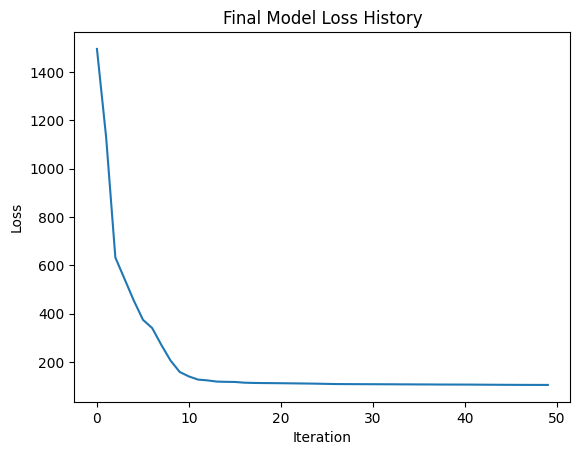

In [11]:

# Instantiate the final model with the best hyperparameters
final_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_layer_sizes=best_hyperparams['hidden_layer_sizes'],
    lambda_reg=best_hyperparams['lambda_reg'],
    initialization_mode=best_hyperparams['initialization_mode'],
    activation=best_hyperparams['activation']
)

# Train the final model
final_model, optimization_results = train_nn(X_train, y_train, final_model, maxiter=200, function_tolerance=1e-4, max_norm=5.0)

# Evaluate on test set
activations, _ = final_model.forward(X_test)
output_layer_index = len(final_model.weights)
y_test_pred = activations[output_layer_index].flatten()

# Compute Mean Absolute Percentage Error (MAPE) and Final Test Loss
test_mape = mean_absolute_percentage_error(y_test.flatten(), y_test_pred)
test_final_loss = np.mean((y_test.flatten() - y_test_pred) ** 2)  # Compute MSE as test error

# Extract final optimization details
avg_iterations = optimization_results['Iteration_number']
avg_optimization_time = optimization_results['optimization_time_seconds']

# Print the required output for the test set
print(f"""
                number of layers: {len(best_hyperparams['hidden_layer_sizes'])}
                number of neurons: {best_hyperparams['hidden_layer_sizes']}
                activation function: {best_hyperparams['activation']}
                initialization_mode: {best_hyperparams['initialization_mode']}
                Lambda: {best_hyperparams['lambda_reg']}
                optimization solver: L-BFGS-B optimizer
                number of iterations: {avg_iterations}
                optimization time: {avg_optimization_time:.4f}
                optimization_message: {optimization_results['Optimization_message']}
                Optimization_Success: {optimization_results['Optimization_Success']}
                Test Error: {test_final_loss:.4f}
                Test MAPE: {test_mape:.4f}
""")

# Plot the loss history
plt.plot(final_model.loss_history)
plt.title('Final Model Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()